In [31]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import animation
import logging
import datetime as dt
from datetime import datetime, timedelta
import pandas as pd
import MySQLdb
from tqdm import tqdm_notebook

In [32]:
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
import collections
from tslearn.preprocessing import TimeSeriesResampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [236]:
from keras.models import Model
from keras import layers
from keras import Input
from keras import regularizers
import keras
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import sklearn.metrics as metrics

In [33]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
     #   print("Normalized confusion matrix")
   # else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           #title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


In [34]:
main_result_abnormal = pd.read_csv('main_input_abnormal.csv')
sub_result_abnormal = pd.read_csv('sub_input_abnormal.csv')

In [35]:
main_result_normal = pd.read_csv('main_input_normal.csv')
sub_result_normal = pd.read_csv('sub_input_normal.csv')

In [36]:
main_result_abnormal = main_result_abnormal[['ID', 'PosX', 'PosY', 'velocity', 'velocity_X',
       'velocity_Y', 'accelerate', 'accelerate_X', 'accelerate_Y', 'Fly_time',
       'Play_time']]
main_result_abnormal['State'] = 'Abnormal'

In [37]:
sub_result_abnormal = sub_result_abnormal[['ID', 'Line_Count', 'Flytime_cal', 'Height_Max',
       'Height_Mean', 'Height_Std', 'Width_Max', 'Width_Mean', 'Width_Std',
       'Play_time_cal', 'Line_Length', 'month_age', 'Boy', 'Girl']]

In [38]:
main_result_normal = main_result_normal[['ID', 'PosX', 'PosY', 'velocity', 'velocity_X',
       'velocity_Y', 'accelerate', 'accelerate_X', 'accelerate_Y', 'Fly_time',
       'Play_time', 'State']]

In [39]:
sub_result_normal = sub_result_normal[['ID', 'Line_Count', 'Flytime_cal', 'Height_Max',
       'Height_Mean', 'Height_Std', 'Width_Max', 'Width_Mean', 'Width_Std',
       'Play_time_cal', 'Line_Length', 'month_age', 'Boy', 'Girl']]

In [43]:
main_result = pd.concat([main_result_normal, main_result_abnormal])

In [44]:
sub_result = pd.concat([sub_result_normal, sub_result_abnormal])

In [46]:
mapPositionDataByID = collections.OrderedDict()
mapStateByID = collections.OrderedDict()

In [47]:
nor_list = ['velocity','velocity_X','velocity_Y','accelerate','accelerate_X','accelerate_Y', 'Fly_time','Play_time']
for _ in nor_list:
    x = main_result[_]
    normalized_df=(x-x.mean())/x.std()
    main_result[_] =  list(normalized_df)

In [48]:
nor_list2 = [ 'Line_Count', 'Flytime_cal', 'Height_Max', 'Height_Mean',
       'Height_Std', 'Width_Max', 'Width_Mean', 'Width_Std', 'Play_time_cal',
       'Line_Length', 'month_age']
for _ in nor_list2:
    x = sub_result[_]
    normalized_df=(x-x.mean())/x.std()
    sub_result[_] =  list(normalized_df)

In [49]:
main_result = pd.get_dummies(main_result, columns=['State'])

In [50]:
main_result.to_csv('딥러닝_메인.csv')
sub_result.to_csv('딥러닝_서브.csv')

In [51]:
main_result = pd.read_csv('딥러닝_메인.csv')
sub_result = pd.read_csv('딥러닝_서브.csv')

In [52]:
main_result = main_result.iloc[:,1:]
sub_result = sub_result.iloc[:,1:]

In [55]:
data_dic=dict(tuple(main_result.groupby('ID')))
for k in data_dic.keys():
    mapPositionDataByID[k]=data_dic[k].iloc[:,1:11].values
    mapStateByID[k]=data_dic[k].iloc[:,-2:].values

In [327]:
x_train, y_train, x_test, y_test, x_train_sub, x_test_sub  = [], [], [] ,[],[],[]
key_train, key_test = train_test_split(list(sub_result['ID']), test_size=0.25, random_state=3)#)#
                                       #stratify = ID_State['State'])

for key in key_train:
    x_train.append(mapPositionDataByID[key])
    y_train.append(mapStateByID[key][0])
    x_train_sub.append(np.array(sub_result.set_index('ID').loc[key,['Line_Count', 'Flytime_cal', 'Height_Max', 'Height_Mean',
       'Height_Std', 'Width_Max', 'Width_Mean', 'Width_Std', 'Play_time_cal',
       'Line_Length', 'month_age', 'Boy', 'Girl']].values))
for key in key_test:
    x_test.append(mapPositionDataByID[key])
    y_test.append(mapStateByID[key][0])
    x_test_sub.append(np.array(sub_result.set_index('ID').loc[key,['Line_Count', 'Flytime_cal', 'Height_Max', 'Height_Mean',
       'Height_Std', 'Width_Max', 'Width_Mean', 'Width_Std', 'Play_time_cal',
       'Line_Length', 'month_age', 'Boy', 'Girl']].values))

In [328]:
x_train_input = TimeSeriesResampler(sz=100).fit_transform(x_train)
x_test_input = TimeSeriesResampler(sz=100).fit_transform(x_test)
#x_train = x_train.reshape(27,-1,10)
#x_train = np.array(x_train, order={'F'})
y_train_input = np.array(y_train)
#x_test = np.array(x_test)
y_test_input = np.array(y_test)

x_train_sub_input = np.array(x_train_sub)
x_test_sub_input = np.array(x_test_sub)

In [329]:
print('x_train shape :', x_train_input.shape)
print('y_train shape :', y_train_input.shape)

print('x_train_sub shape :', x_train_sub_input.shape)
print('y_train_sub shape :', x_test_sub_input.shape)

print('x_test shape :', x_test_input.shape)
print('y_test shape :', y_test_input.shape)

x_train shape : (170, 100, 10)
y_train shape : (170, 2)
x_train_sub shape : (170, 13)
y_train_sub shape : (57, 13)
x_test shape : (57, 100, 10)
y_test shape : (57, 2)


In [330]:
sub_input = Input(shape=(13,), dtype = 'float32', name='sub')
embedded_sub = layers.Reshape((-1,1))(sub_input)
encoded_sub = layers.Conv1D(8,kernel_size=3,strides=1,padding='same', activation='relu',
                                              activity_regularizer=regularizers.l2(0.001))(embedded_sub)
encoded_sub = layers.Conv1D(16,kernel_size=3, strides=1, padding='same', activation='relu', 
                         activity_regularizer=regularizers.l2(0.001))(encoded_sub)
encoded_sub = layers.Conv1D(32,kernel_size=3, strides=1, padding='same', activation='relu', 
                         activity_regularizer=regularizers.l2(0.001))(encoded_sub)
pooled_sub = keras.layers.GlobalAveragePooling1D()(encoded_sub)

In [331]:
main_input = Input(shape=(None,10), dtype = 'float32', name='main')
embedded_main = layers.Reshape((-1,1))(main_input)

encoded_main = layers.Conv1D(8, kernel_size=3, strides=1, padding='same', activation='relu', 
                         activity_regularizer=regularizers.l2(0.001))(embedded_main)
encoded_main = layers.Conv1D(16,kernel_size=3, strides=1, padding='same', activation='relu', 
                         activity_regularizer=regularizers.l2(0.001))(encoded_main)
encoded_main = layers.Conv1D(32,kernel_size=3, strides=1, padding='same', activation='relu', 
                         activity_regularizer=regularizers.l2(0.001))(encoded_main)

pooled_main = keras.layers.GlobalAveragePooling1D()(encoded_main)

In [332]:
concatenated = layers.concatenate([pooled_main, pooled_sub],axis=-1)

In [333]:
answer = layers.Dense(2, activation='softmax')(concatenated)

In [334]:
model = Model([ main_input,sub_input], answer)

In [335]:
optimizer = keras.optimizers.Adam()#learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [336]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main (InputLayer)               (None, None, 10)     0                                            
__________________________________________________________________________________________________
sub (InputLayer)                (None, 13)           0                                            
__________________________________________________________________________________________________
reshape_20 (Reshape)            (None, None, 1)      0           main[0][0]                       
__________________________________________________________________________________________________
reshape_19 (Reshape)            (None, 13, 1)        0           sub[0][0]                        
___________________________________________________________________________________________

In [ ]:
history = model.fit([x_train_input,x_train_sub_input], y_train_input, epochs=350, batch_size=10, validation_split=0.2)

In [338]:
predictions = model.predict([x_test_input, x_test_sub_input])

In [339]:
y_pred = (predictions > 0.5) #이 PRediction의 값을 제시

In [340]:
class_names = np.array([ 'Normal', 'Abnoraml'])

In [341]:
print('Accuracy : ', round(accuracy_score(y_test_input.argmax(axis=1), y_pred.argmax(axis=1)),2))
print('F1 Score : ', round(f1_score(y_test_input.argmax(axis=1), y_pred.argmax(axis=1)),2))
print('Precision : ', round(precision_score(y_test_input.argmax(axis=1), y_pred.argmax(axis=1)),2))
print('Recall : ', round(recall_score(y_test_input.argmax(axis=1), y_pred.argmax(axis=1)),2))

Accuracy :  0.88
F1 Score :  0.92
Precision :  0.91
Recall :  0.93


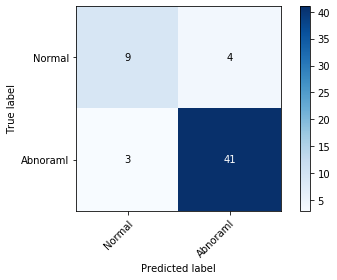

In [342]:
plot_confusion_matrix(y_test_input.argmax(axis=1), y_pred.argmax(axis=1), classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

In [343]:
print('AUC : ', round(roc_auc_score(y_test_input.argmax(axis=1), y_pred.argmax(axis=1)),2))

AUC :  0.81


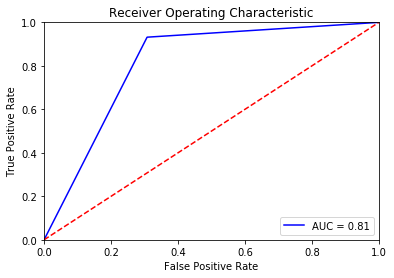

In [344]:
fpr, tpr, threshold = metrics.roc_curve(y_test_input.argmax(axis=1), y_pred.argmax(axis=1))
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

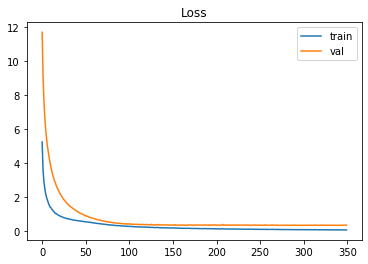

In [272]:
# plot loss during training

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
# plot accuracy during training


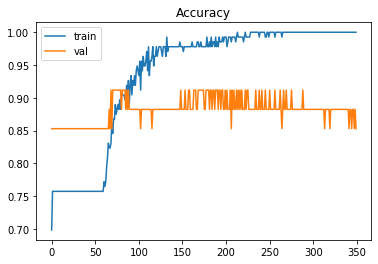

In [273]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show()

# 특정 유저의 확률

In [228]:
key_user_id = list(mapPositionDataByID.keys())[5]

In [230]:
x_test_one, y_test_one, x_test_sub_one=[],[],[]

In [231]:
x_test_one.append(mapPositionDataByID[key_user_id])
y_test_one.append(mapStateByID[key_user_id][0])
x_test_sub_one.append(np.array(sub_result.set_index('ID').loc[key_user_id,['Line_Count', 'Flytime_cal', 'Height_Max', 'Height_Mean',
   'Height_Std', 'Width_Max', 'Width_Mean', 'Width_Std', 'Play_time_cal',
   'Line_Length', 'month_age', 'Boy', 'Girl']].values))

In [232]:
x_test_input = TimeSeriesResampler(sz=100).fit_transform(x_test_one)
y_test_input = np.array(y_test_one)
x_test_sub_input = np.array(x_test_sub_one)

In [233]:
predictions = model.predict([x_test_input, x_test_sub_input])

In [234]:
print('발달 장애아동일 확률 : ', str(round(predictions[0][0]*100,2))+'%') # 발달 장애일 확률

발달 장애아동일 확률 :  98.89%
